In [ ]:
import os
import random
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

In [ ]:
# Create results directory
results_dir = "results_cnn_residualblock"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Setup with optimizations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Results will be saved to: results_cnn_residualblock
Using device: cpu


In [ ]:
# Enhanced transforms with medical image specific augmentations
train_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Better crop strategy
        transforms.RandomRotation(degrees=20),  # Increased rotation
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(
            p=0.2
        ),  # Medical images can be flipped vertically
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        # Add Gaussian blur occasionally
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.ToTensor(),
        # Better normalization for medical images
        transforms.Normalize(mean=[0.485], std=[0.229]),
        # Add random noise
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]
)

In [ ]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block for channel attention"""

    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class EnhancedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True):
        super(EnhancedResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # SE block for attention
        self.se = SEBlock(out_channels) if use_se else None

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        if self.se is not None:
            out = self.se(out)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
# Load data
data_dir = "./chest_Xray"
print("Loading datasets...")
train_set = datasets.ImageFolder(
    os.path.join(data_dir, "train"), transform=train_transform
)
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=test_transform)
test_set = datasets.ImageFolder(
    os.path.join(data_dir, "test"), transform=test_transform
)

class_names = train_set.classes
print(f"Classes: {class_names}")

# Get class distribution and create weighted sampler
train_labels = [train_set[i][1] for i in range(len(train_set))]
class_counts = Counter(train_labels)
print(f"Class distribution: {dict(class_counts)}")

# Use WeightedRandomSampler for better class balance
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_labels), y=train_labels
)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(sample_weights), replacement=True
)

print(f"Class weights: {class_weights}")
print(
    f"Dataset sizes - Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}"
)

Loading datasets...
Classes: ['NORMAL', 'PNEUMONIA']
Class distribution: {0: 1341, 1: 3875}
Class weights: [1.9448173  0.67303226]
Dataset sizes - Train: 5216, Val: 16, Test: 624


In [ ]:
# Better batch size for higher resolution
batch_size = 16
num_workers = 0
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)

        return out

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Initial convolution with proper padding
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        # Residual blocks with proper channel progression
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling and classifier
        # TODO: what is 1, 1 in AdaptiveAvgPool2d?
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            # TODO: why are we using constant initialization for BatchNorm?
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        try:
            x = self.conv1(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.global_pool(x)
            x = self.classifier(x)
            return x
        except RuntimeError as e:
            print(f"Forward pass error: {e}")
            print(f"Input shape: {x.shape if 'x' in locals() else 'Unknown'}")
            raise


In [ ]:
# Fixed model initialization with better parameters
try:
    model = CNN(len(class_names)).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

except Exception as e:
    print(f"Model initialization error: {e}")
    raise

# Mixed precision training
scaler = torch.amp.GradScaler("cuda") if device.type == "cuda" else None

# Better loss function and optimizer
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# Reduced learning rate for stability
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# More conservative scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=15,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy="cos",
)

Model parameters: 11,302,594


In [ ]:
# Fixed training function with better error handling
def train_epoch(
    model, train_loader, criterion, optimizer, scheduler, device, scaler=None
):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    try:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = (
                images.to(device, non_blocking=True),
                labels.to(device, non_blocking=True),
            )

            # Clear gradients
            optimizer.zero_grad()

            try:
                if scaler is not None and device.type == "cuda":
                    with torch.amp.autocast("cuda"):
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                scheduler.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Progress update every 50 batches
                if batch_idx % 50 == 0:
                    print(
                        f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}"
                    )

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {e}")
                print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
                raise

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    except Exception as e:
        print(f"Training epoch error: {e}")
        raise

In [ ]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = (
                images.to(device, non_blocking=True),
                labels.to(device, non_blocking=True),
            )

            if device.type == "cuda":
                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_model_state = None
patience_counter = 0
early_stop_patience = 8

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device, scaler
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]["lr"]
    print(
        f"Epoch {epoch + 1:2d}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
        f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s"
    )

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

Starting training...
Batch 0/326, Loss: 0.7036
Batch 50/326, Loss: 0.5566
Batch 100/326, Loss: 0.4032
Batch 150/326, Loss: 0.3661
Batch 200/326, Loss: 0.3796
Batch 250/326, Loss: 0.2712
Batch 300/326, Loss: 0.4603
Epoch  1/10 | Train Loss: 0.4773 Acc: 0.7922 | Val Loss: 1.4397 Acc: 0.6250 | LR: 0.000152 | Time: 763.3s
Batch 0/326, Loss: 0.3356
Batch 50/326, Loss: 0.3264
Batch 100/326, Loss: 0.4234
Batch 150/326, Loss: 0.3786
Batch 200/326, Loss: 0.2799
Batch 250/326, Loss: 0.3342
Batch 300/326, Loss: 0.2943
Epoch  2/10 | Train Loss: 0.4039 Acc: 0.8345 | Val Loss: 0.5865 Acc: 0.7500 | LR: 0.000437 | Time: 868.9s
Batch 0/326, Loss: 0.6156
Batch 50/326, Loss: 0.3766
Batch 100/326, Loss: 0.2409
Batch 150/326, Loss: 0.4322
Batch 200/326, Loss: 0.3604
Batch 250/326, Loss: 0.3453
Batch 300/326, Loss: 0.3665
Epoch  3/10 | Train Loss: 0.3685 Acc: 0.8453 | Val Loss: 0.6510 Acc: 0.5000 | LR: 0.000761 | Time: 877.8s
Batch 0/326, Loss: 0.2687
Batch 50/326, Loss: 0.2337
Batch 100/326, Loss: 0.3313
B

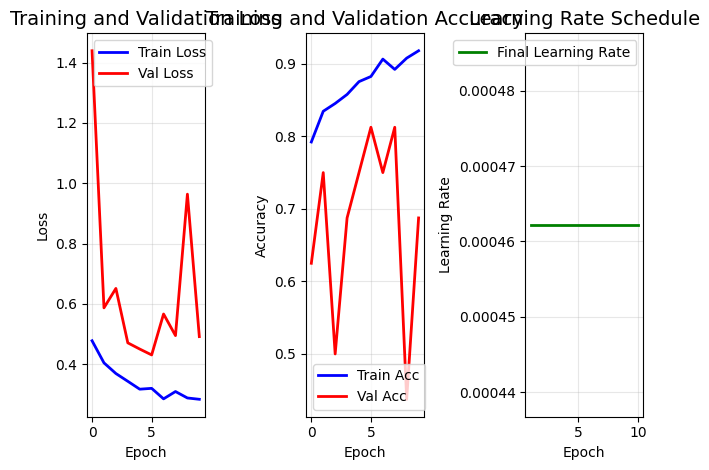

In [ ]:
# TODO: remove matplotlib from your life
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
plt.plot(val_losses, label="Val Loss", color="red", linewidth=2)
plt.title("Training and Validation Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train Acc", color="blue", linewidth=2)
plt.plot(val_accs, label="Val Acc", color="red", linewidth=2)
plt.title("Training and Validation Accuracy", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
try:
    final_lr = optimizer.param_groups[0]["lr"]
    plt.plot(
        epochs_range,
        [final_lr] * len(epochs_range),
        label="Final Learning Rate",
        color="green",
        linewidth=2,
    )
except:
    plt.plot(
        epochs_range,
        [0.0005] * len(epochs_range),
        label="Initial Learning Rate",
        color="green",
        linewidth=2,
    )

plt.title("Learning Rate Schedule", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, "training_metrics.png"), dpi=300, bbox_inches="tight"
)
plt.show()

In [ ]:
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time:.1f}s ({total_time / 60:.1f} minutes)")

# Load best model
model.load_state_dict(best_model_state)
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Save training plots
plt.figure(figsize=(15, 5))


Training completed in 6257.8s (104.3 minutes)
Best validation accuracy: 0.8125


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [ ]:
# Comprehensive test evaluation
def evaluate_model_comprehensive(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)

            if device.type == "cuda":
                with torch.amp.autocast("cuda"):
                    outputs = model(images)
            else:
                outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [ ]:
print("Evaluating on test set...")
test_labels, test_preds, test_probs = evaluate_model_comprehensive(
    model, test_loader, device, class_names
)

test_accuracy = np.mean(test_preds == test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate and save classification report
print("\nClassification Report:")
class_report = classification_report(
    test_labels, test_preds, target_names=class_names, output_dict=True
)
print(classification_report(test_labels, test_preds, target_names=class_names))

# Save classification report as parquet
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_parquet(os.path.join(results_dir, "classification_report.parquet"))
print(f"Classification report saved to {results_dir}/classification_report.parquet")

Evaluating on test set...
Test Accuracy: 0.8702

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.77      0.93      0.84       234
   PNEUMONIA       0.95      0.83      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.87      0.87       624

Classification report saved to results_cnn_residualblock/classification_report.parquet


Confusion matrix saved to results_cnn_residualblock/confusion_matrix.parquet


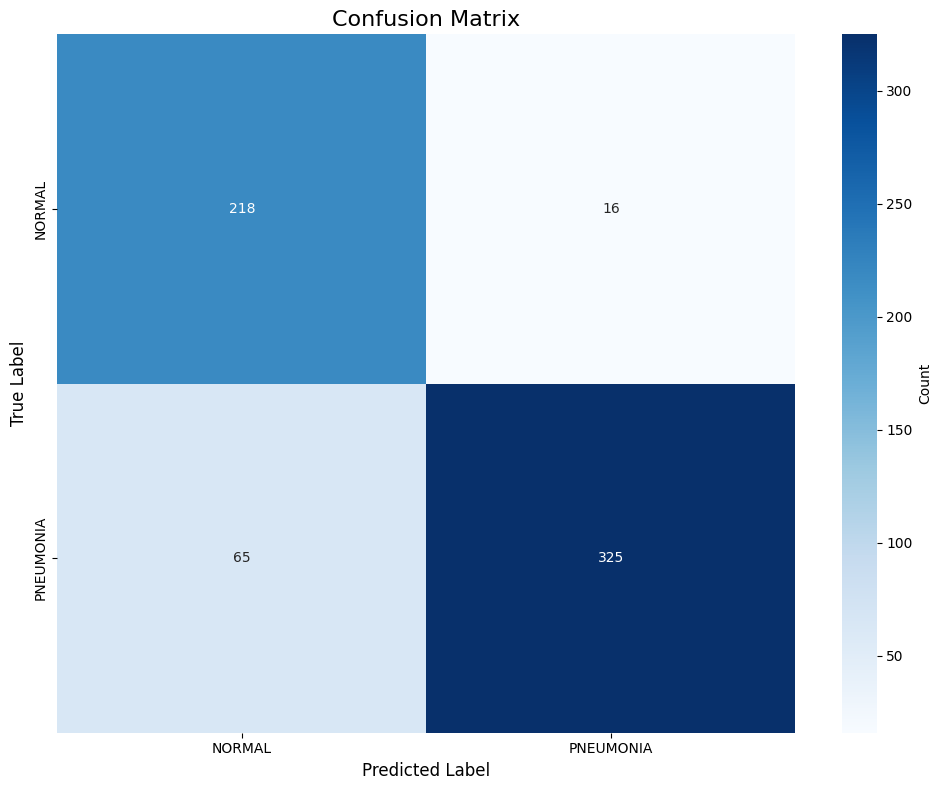


Detailed Per-Class Analysis:
NORMAL: 234 samples, Accuracy: 0.9316
PNEUMONIA: 390 samples, Accuracy: 0.8333


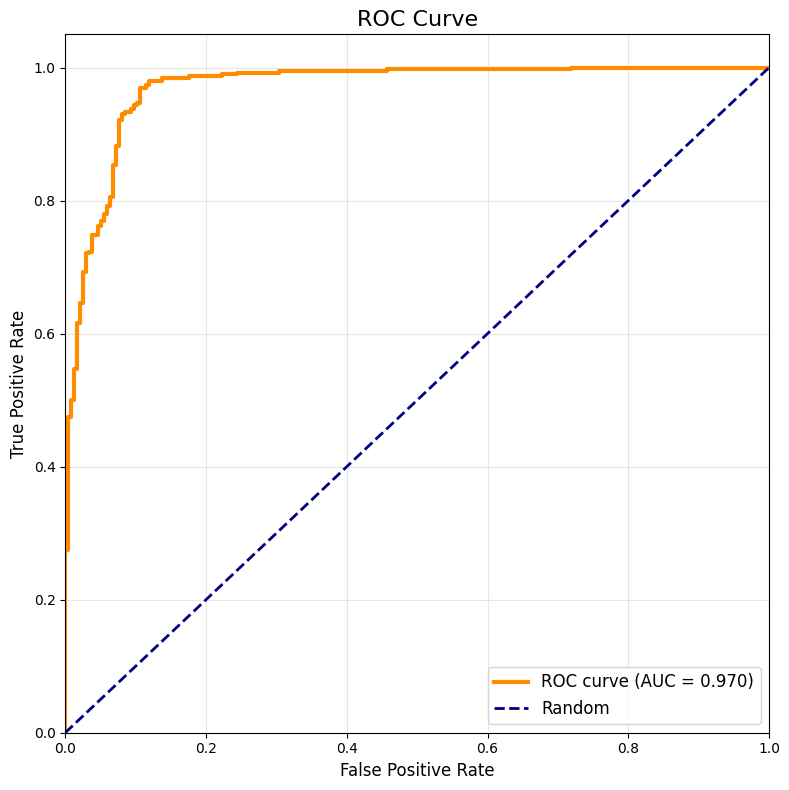

In [ ]:
# Create and save detailed confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_parquet(os.path.join(results_dir, "confusion_matrix.parquet"))
print(f"Confusion matrix saved to {results_dir}/confusion_matrix.parquet")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, "confusion_matrix.png"), dpi=300, bbox_inches="tight"
)
plt.show()

# Detailed per-class metrics
print("\nDetailed Per-Class Analysis:")
for i, class_name in enumerate(class_names):
    class_mask = test_labels == i
    class_accuracy = np.mean(test_preds[class_mask] == test_labels[class_mask])
    class_count = np.sum(class_mask)
    print(f"{class_name}: {class_count} samples, Accuracy: {class_accuracy:.4f}")

# ROC Curve for binary classification
if len(class_names) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(
        fpr, tpr, color="darkorange", lw=3, label=f"ROC curve (AUC = {roc_auc:.3f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(
        os.path.join(results_dir, "roc_curve.png"), dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Save ROC data
    roc_data = pd.DataFrame({"fpr": fpr, "tpr": tpr, "auc": roc_auc})
    roc_data.to_parquet(os.path.join(results_dir, "roc_data.parquet"))

In [ ]:
# Save comprehensive results summary
results_summary = {
    "training_time_seconds": total_time,
    "training_time_minutes": total_time / 60,
    "best_validation_accuracy": best_val_acc,
    "test_accuracy": test_accuracy,
    "total_epochs": len(train_losses),
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "final_train_acc": train_accs[-1],
    "final_val_acc": val_accs[-1],
    "class_names": class_names,
    "class_distribution": dict(class_counts),
    "model_parameters": sum(p.numel() for p in model.parameters()),
}

# Save results summary
results_df = pd.DataFrame([results_summary])

In [ ]:
# Save model with comprehensive metadata
torch.save(
    {
        "model_state_dict": best_model_state,
        "model_architecture": "CNN",
        "class_names": class_names,
        "test_accuracy": test_accuracy,
        "best_val_accuracy": best_val_acc,
        "training_time": total_time,
        "total_epochs": len(train_losses),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "class_weights": class_weights.tolist(),
        "results_summary": results_summary,
    },
    os.path.join(results_dir, "improved_chest_xray_model.pth"),
)

print("\nFinal Results Summary:")
print(f"Training Time: {total_time:.1f}s ({total_time / 60:.1f} minutes)")
print(f"Total Epochs: {len(train_losses)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")


Final Results Summary:
Training Time: 6257.8s (104.3 minutes)
Total Epochs: 10
Best Validation Accuracy: 0.8125
Test Accuracy: 0.8702
Model Parameters: 11,302,594
